In [1]:
import matplotlib.pyplot as plt
import emcee
import numpy as np
import corner

In [2]:
from astropy.io import ascii
data=ascii.read('gw170817_afterglow_data_full.txt')
data

DateUT,T,Telescope,Freq,FluxD,FluxDErr
str24,float64,str10,float64,str7,float64
2017-Aug-18.10,0.57,VLA,9700000000.0,<144,--
2017-Aug-18.1,0.6,Swift,2.41e+17,<7.8e-3,--
2017-Aug-18.21,0.68,ATCA,8500000000.0,<120,--
2017-Aug-18.21,0.68,ATCA,10500000000.0,<150,--
2017-Aug-18.2,0.7,NuSTAR,1.2e+18,<7.3e-4,--
2017-Aug-18.46,0.93,uGMRT,610000000.0,<195,--
...,...,...,...,...,...
2021-Feb-20,1283.0,ATCA,2100000000.0,<75,--
2021-Apr-06,1328.0,ATCA,2100000000.0,<54,--


In [14]:
from astropy.table import vstack

#VLA 3GHz
freq_subset=data['Freq']==3000000000
telescope_subset=data['Telescope']=='VLA'

#Chandra
telescope_subset_2=data['Telescope']=='Chandra'

#FluxDensities with exact values
properflux_subset=[]

#Remove data with uncertain Flux Densities
for i in range(215):
    try:
        data['FluxD'][i]=float(data['FluxD'][i])
        properflux_subset.append(True)
        data['T'][i]=float(data['T'][i])
    except:
        properflux_subset.append(False)
        continue

# VLA 3GHz data
properflux_subset=np.array(properflux_subset)
subset=np.logical_and(freq_subset, telescope_subset)
subset2=np.logical_and(subset, properflux_subset)
vla=data[subset2]
vla['FluxD']=vla['FluxD'].astype(float)

#Chandra Data
subset3=np.logical_and(properflux_subset,telescope_subset_2)
chandra=data[subset3]
chandra['FluxD']=chandra['FluxD'].astype(float)

# All Data
filtered_table=vstack([vla,chandra])
filtered_table

DateUT,T,Telescope,Freq,FluxD,FluxDErr
str24,float64,str10,float64,float64,float64
2017-Sep-2.9,16.4,VLA,3000000000.0,18.7,6.3
2017-Sep-3.9,17.4,VLA,3000000000.0,15.1,3.9
2017-Sep-4.9,18.3,VLA,3000000000.0,14.5,3.7
2017-Sep-8.9,22.4,VLA,3000000000.0,22.5,3.4
2017-Sep-10.8,24.2,VLA,3000000000.0,25.6,2.9
2017-Sep-17.8,31.3,VLA,3000000000.0,34.0,3.6
...,...,...,...,...,...
2018-Jan-23,158.0,Chandra,2.41e+17,0.00219,0.000183
2018-May-04,259.0,Chandra,2.41e+17,0.00115,0.00014


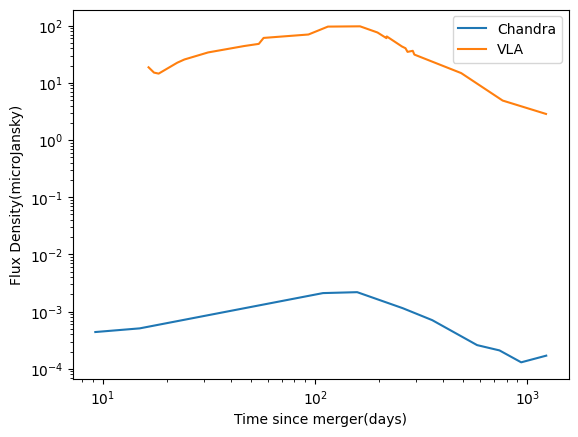

In [4]:
import matplotlib.pyplot as plt

telescopes=filtered_table['Telescope']
chandra_position=np.where(telescopes=='Chandra')
vla_position=np.where(telescopes=='VLA')

plt.loglog(np.array(filtered_table['T'])[chandra_position],filtered_table['FluxD'][chandra_position],label='Chandra')
plt.loglog(np.array(filtered_table['T'])[vla_position],filtered_table['FluxD'][vla_position],label='VLA')

plt.xlabel('Time since merger(days)')
plt.ylabel('Flux Density(microJansky)')
plt.legend()
plt.show()

In [5]:
t_data=filtered_table['T']
v_data=filtered_table['Freq']
y_data=np.log10(filtered_table['FluxD'])

In [6]:
def model(theta, X):
    t,v=X
    s,beta,a1,a2,tp,log10Fp=theta
    return np.log10(2)/s + beta*np.log10(v/3e+9)+log10Fp -(1/s)*np.log10((t/tp)**(-s*a1)+(t/tp)**(-s*a2))

def loglike(theta,X,y,yerr):
    return -0.5*np.sum(((y-model(theta,X))/yerr)**2)

def logprior(theta):
    s,beta,a1,a2,tp,log10Fp=theta
    if 0<s<7 and -1<beta<1 and -2<a1<2 and -2<a2<2 and 90<tp<150 and -5<log10Fp<3:
        return 0.0
    return -np.inf

def logprob(theta,X,y,yerr):
    lp=logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return loglike(theta,X,y,yerr)

In [7]:
y_error=0.05*y_data
data_tuple=((t_data,v_data),y_data,y_error)
nwalkers=100
nsteps=1000
initial=np.array([1,-0.4,0.9,-1.5,100,2])
ndim=len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [8]:
def main(p0,nwalkers,nsteps,ndim,logprob,data_tuple):
    sampler=emcee.EnsembleSampler(nwalkers,ndim,logprob,args=data_tuple)
    print('Running burn-in..')
    p0,_,_=sampler.run_mcmc(p0,100)
    sampler.reset()
    print('Running production...')
    pos,prob,state=sampler.run_mcmc(p0,nsteps)
    return sampler,pos,prob,state

sampler,pos,prob,state = main(p0,nwalkers,nsteps,ndim,logprob,data_tuple)

Running burn-in..
Running production...


In [9]:
X=(t_data,v_data)
def plotter(sampler,X=X,y_data=y_data):
    t_data_vla=t_data[v_data==3e+9]
    t_data_chandra=t_data[v_data!=3e+9]
    
    plt.ion()
    plt.plot(t_data_vla,filtered_table['FluxD'][vla_position],label='VLA')
    plt.plot(t_data_chandra,filtered_table['FluxD'][chandra_position],label='Chandra')
    plt.xscale('log')
    plt.yscale('log')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(t_data_vla, np.power(10,model(theta, X)[v_data==3e+9]), color="r", alpha=0.1)
        plt.plot(t_data_chandra, np.power(10,model(theta, X)[v_data!=3e+9]), color="blue", alpha=0.1)
        plt.xlabel('Time since merger(days)')
        plt.ylabel('Flux Density in microJansky')
        plt.title('Plot of Random samples generated during MCMC Analysis')
        plt.legend()
    plt.show()

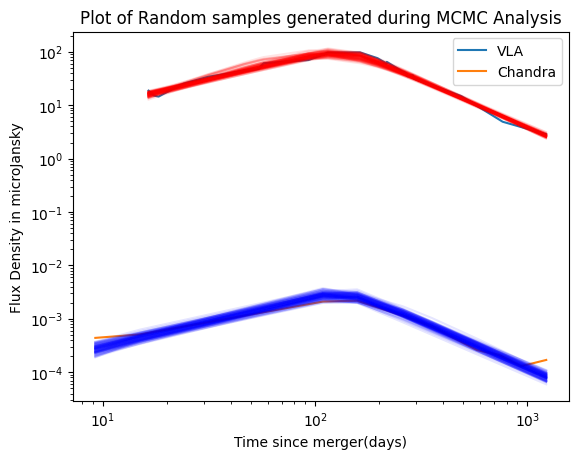

In [10]:
plotter(sampler)

In [11]:
samples=sampler.flatchain
theta_max=samples[np.argmax(sampler.flatlnprobability)]
theta_max

array([  3.68255265,  -0.57082683,   0.91042339,  -1.75014178,
       142.68732222,   1.98692858])

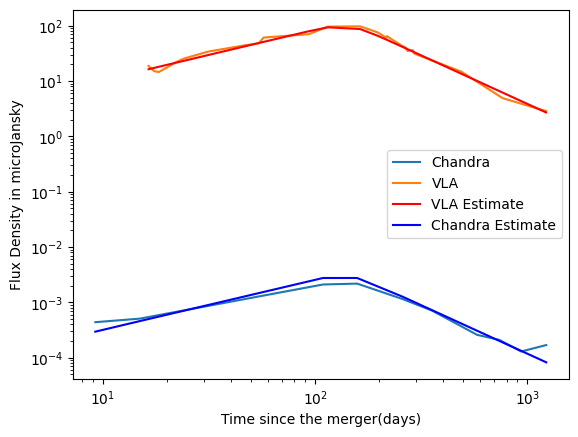

In [12]:
best_fit_model=model(theta_max,X)

t_data_vla=t_data[v_data==3e+9]
t_data_chandra=t_data[v_data!=3e+9]

plt.loglog(np.array(filtered_table['T'])[chandra_position],filtered_table['FluxD'][chandra_position],label='Chandra')
plt.loglog(np.array(filtered_table['T'])[vla_position],filtered_table['FluxD'][vla_position],label='VLA')
plt.plot(t_data_vla, np.power(10,model(theta_max, X)[v_data==3e+9]), color="r",label='VLA Estimate')
plt.plot(t_data_chandra, np.power(10,model(theta_max, X)[v_data!=3e+9]), color="blue",label='Chandra Estimate')
plt.legend()
plt.ylabel('Flux Density in microJansky')
plt.xlabel('Time since the merger(days)')
plt.show()

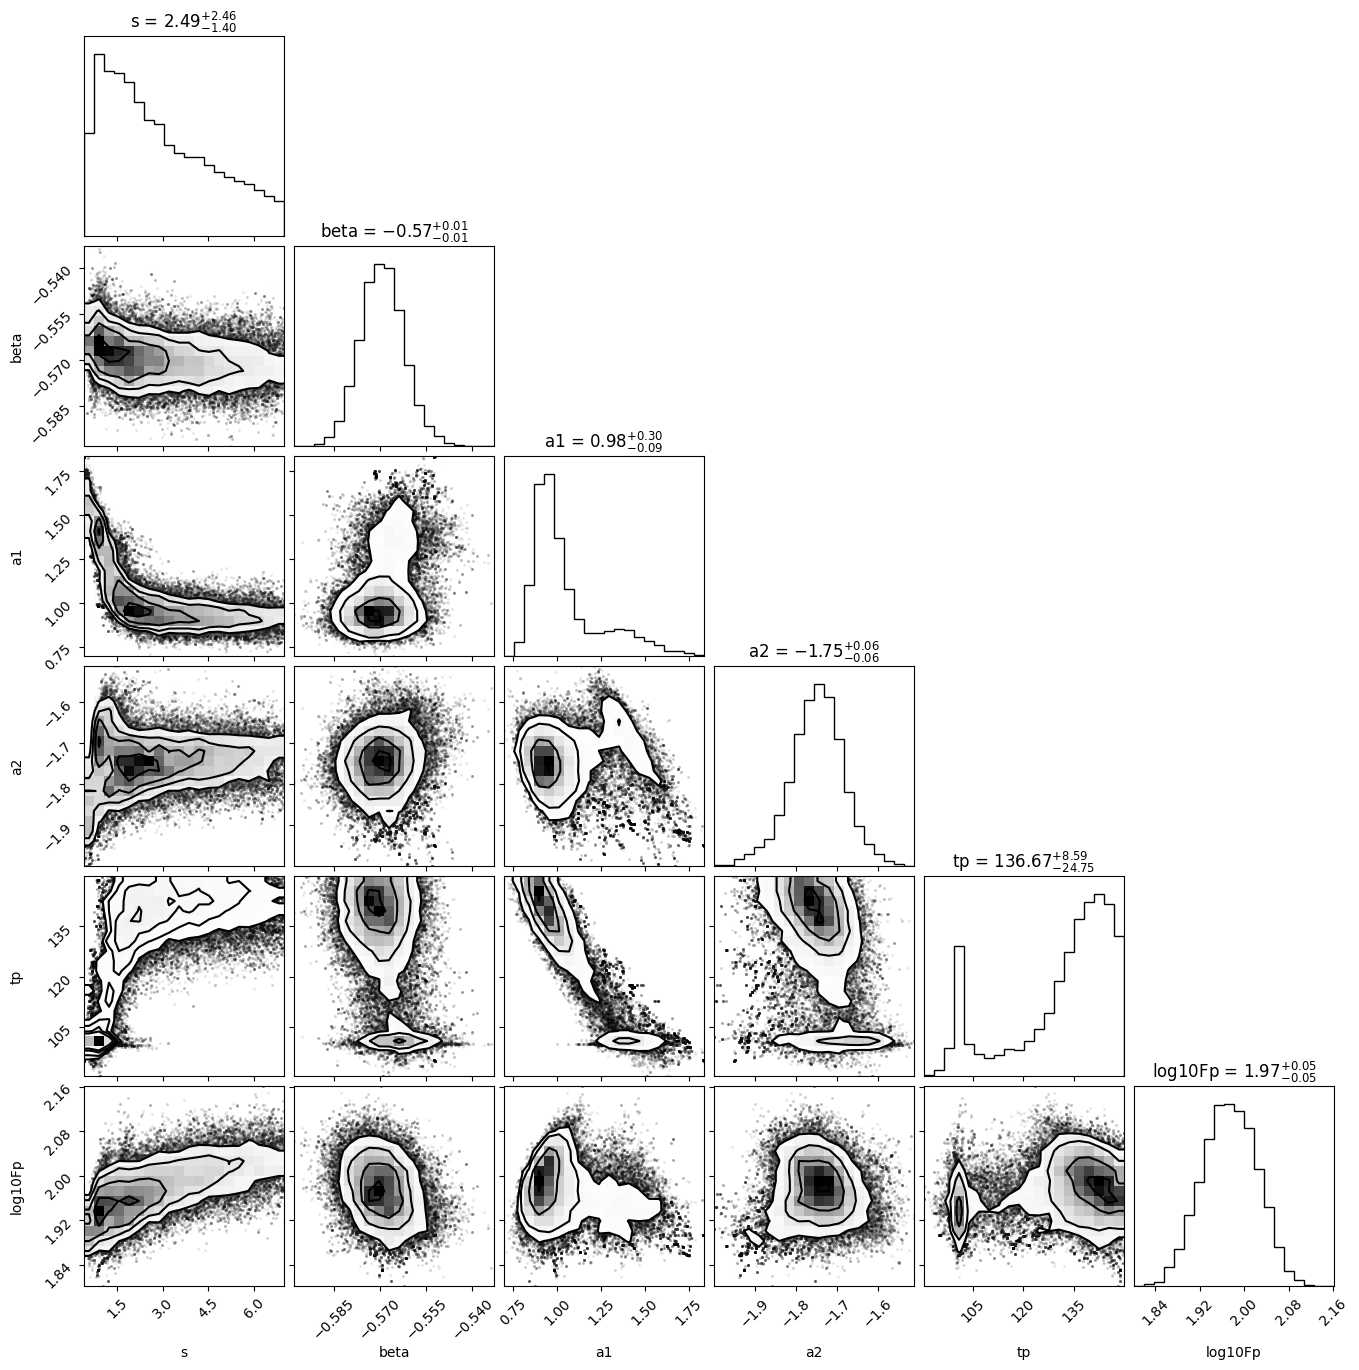

In [13]:
labels = ['s','beta','a1','a2','tp','log10Fp']
fig = corner.corner(samples,show_titles=True,labels=labels)